In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/Vanilla.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown.py'] ['Without simplification', 'Simplifier Bottom Up', 'Simplifier Top Down']
(11, 14)
['Simplifier Bottom Up' 'Simplifier Top Down']
['Airfoil']
range(10, 250, 25)


In [2]:
all_data = []
for i, row in results_df.iterrows():
    model, dataset, random_state = row.loc[['model', 'dataset', 'random_state']]

    files = glob(f"{results_path}/{dnames_to_ugly[dataset]}/{nice_to_ugly[model]}/"
                f"*{random_state}_evolution.csv")

    for file in files:
        data = pd.read_csv(file)
        
        for gen in gens:
            try:
                row = data[data['gen']==gen].iloc[0] # should have just 1 row
            except Exception as e:
                pass
                # print(e)
                # print(file, gen)
                # print(row)

            all_data.append((model, dataset, *row))
            
all_data_df = pd.DataFrame(all_data, 
                           columns=(
                               'model',
                               'dataset',
                               *row.index
                           ))

all_data_df = all_data_df.replace([np.inf, -np.inf], np.nan).dropna()

print(all_data_df.shape)
print(all_data_df['model'].unique())
print(all_data_df['dataset'].unique())
all_data_df.sample(5)

(110, 27)
['Simplifier Bottom Up' 'Simplifier Top Down']
['Airfoil']


,model,dataset,gen,evals,best_size,n_simplifications,n_new_hashes,avg train error,avg train size,avg val error,...,std val error,std val size,min train error,min train size,min val error,min val size,max train error,max train size,max val error,max val size
71,Simplifier Top Down,Airfoil,35.0,100.0,13.0,89.0,96.0,47.511109,2.41,49.874534,...,2.749821,1.772541,33.253000,2.0,32.908050,2.0,48.044910,13.0,50.504887,13.0
91,Simplifier Top Down,Airfoil,35.0,100.0,9.0,64.0,65.0,44.939952,2.47,48.563669,...,3.794802,1.431468,21.527896,2.0,24.828549,2.0,45.931030,9.0,49.549174,9.0
7,Simplifier Bottom Up,Airfoil,185.0,100.0,8.0,116.0,73.0,49.552700,2.31,42.916807,...,3.579820,1.055415,27.382532,2.0,23.727231,2.0,50.644178,8.0,43.827324,8.0
6,Simplifier Bottom Up,Airfoil,160.0,100.0,8.0,92.0,44.0,49.322205,2.36,42.717234,...,4.049051,1.153430,27.382532,2.0,23.727231,2.0,50.644178,8.0,43.827324,8.0
25,Simplifier Bottom Up,Airfoil,135.0,100.0,15.0,84.0,53.0,46.983686,2.76,44.476643,...,4.575186,2.186870,21.587448,2.0,23.497337,2.0,49.196531,15.0,46.000808,15.0


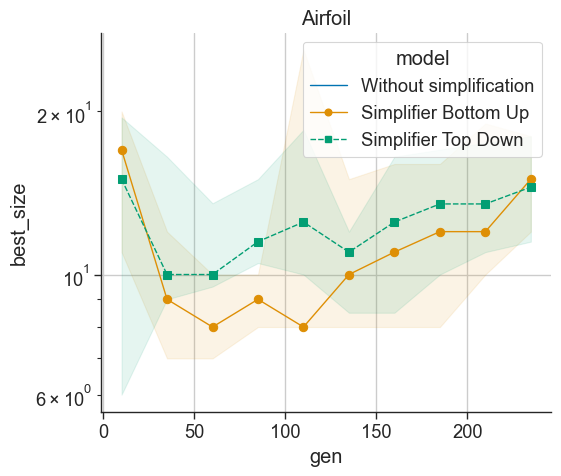

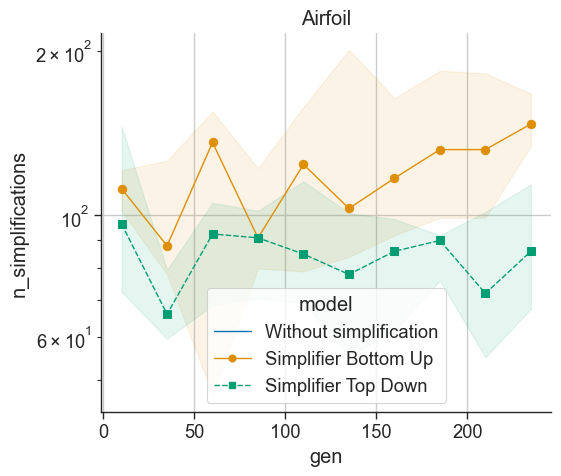

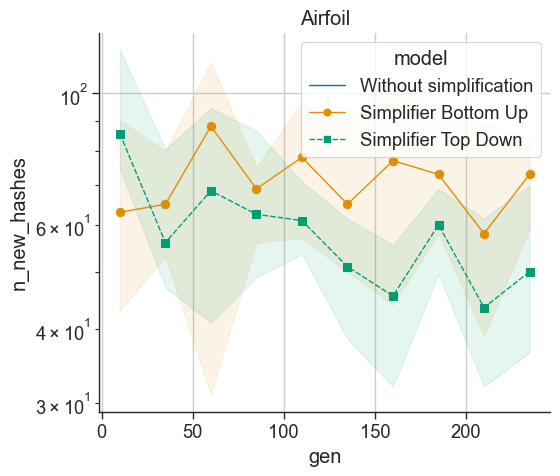

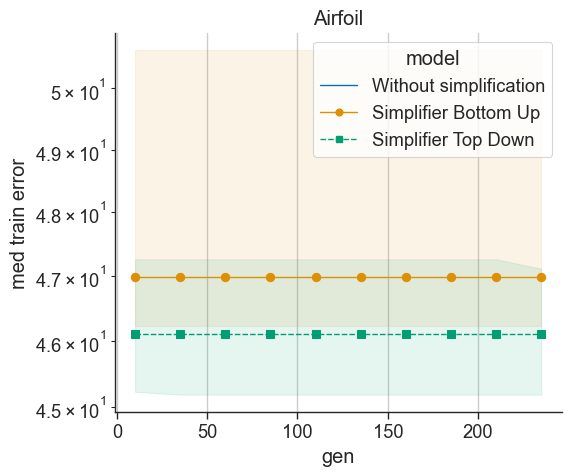

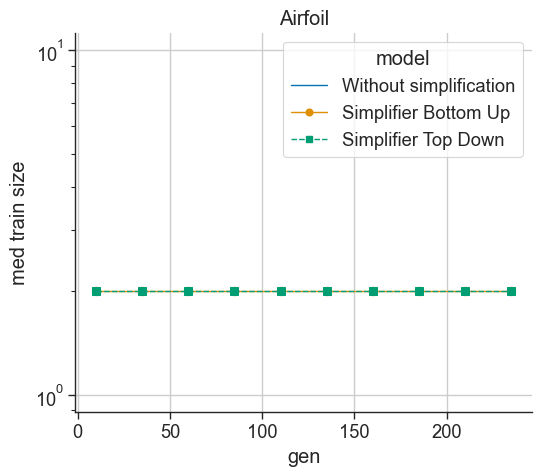

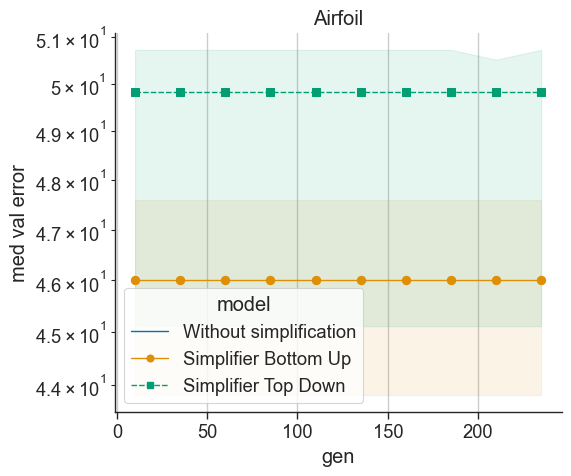

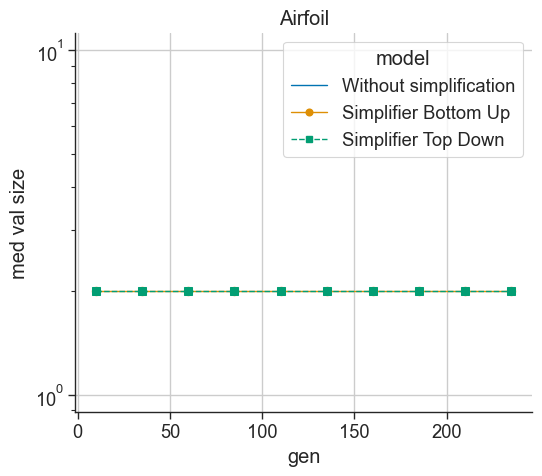

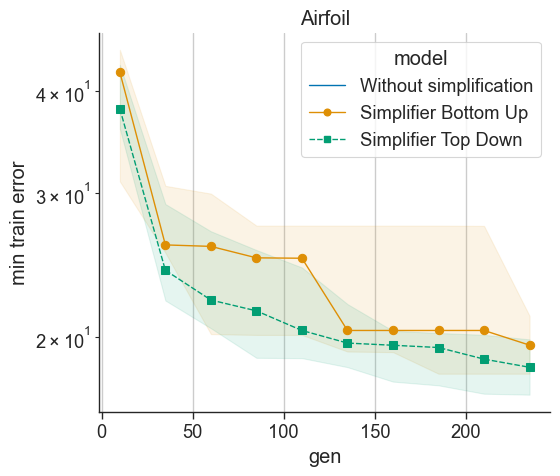

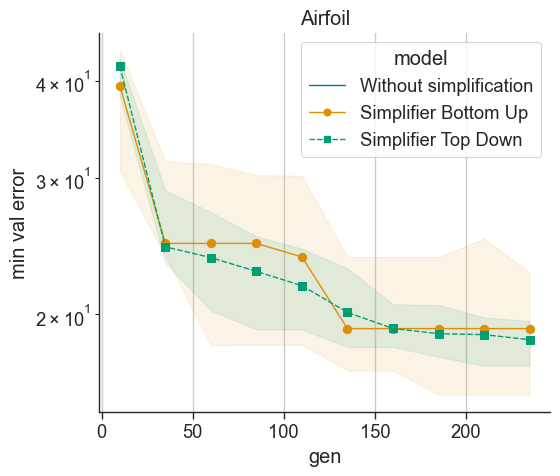

In [3]:
for col in [
    'best_size','n_simplifications','n_new_hashes','med train error','med train size',
    'med val error','med val size','min train error','min val error'
]:
    
    # about errors: https://seaborn.pydata.org/tutorial/error_bars.html
    g = sns.relplot(
        data=all_data_df,
        x="gen", y=col, col="dataset", hue="model",
        style="model", col_wrap=4, markers=marker_choice, markeredgecolor=None, 
        kind="line", facet_kws={'sharey': False, 'sharex': False, 'legend_out':False}, #errorbar=None, #('ci', 50),
        hue_order = order, estimator=np.median, markersize=6,
        
        # err_style='bars', err_kws={'capsize':2.0, 'linewidth':0.75},
        err_style='band', err_kws={'alpha':0.1},
    )
    g.set_titles("{col_name}")

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='both', linewidth=1)

    if True: # use log scale
        #g.set(xscale="log")
        g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{col}.pdf")
    plt.savefig(f"../paper/figs/{col}.png")
    plt.show()